In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# II La régression logistique en pratique
df = pd.read_csv("../data/gold_concours.csv")

In [82]:
# met PaperlessBilling en binaire
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
# fait pour pohneService
df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
# fait pour Dependents
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
# fait pour Partner
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
# fait aussi pour SeniorCitizen yes 1 no 0
df['SeniorCitizen'] = df['SeniorCitizen'].map({'Yes': 1, 'No': 0})
# fait aussi le gender
df['gender'] = df['gender'].map({'Female': 0, 'Male' : 1})
# fait une boucle pour voir les valeurs uniques de chaque colonne
for col in df.columns:
    print(col, df[col].unique())

gender [0 1]
SeniorCitizen [0 1]
Partner [1 0]
Dependents [0 1]
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService [0 1]
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling [1 0]
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn ['No' 'Yes']
nb_service_internet [1 2 3 0 4 5 6]


In [83]:
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, stratify=y,random_state=42)

In [84]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y_train =  labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

# Convert y_train and y_test to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
from sklearn.preprocessing import StandardScaler , MinMaxScaler , RobustScaler
from sklearn.preprocessing import PolynomialFeatures

set_config(display='diagram')

categorical_features = ['MultipleLines', 'InternetService', 'Contract' ,
       'PaymentMethod'
       ]

numerical_features = [
    'TotalCharges',
    "tenure",
    "MonthlyCharges",
    'nb_service_internet',
    'PaperlessBilling',
    'PhoneService',
    'Dependents',
    'Partner',
    'gender', 
    'SeniorCitizen'
]

numerical_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('PolynomialFeatures', PolynomialFeatures(degree=3))
])

# Create the OneHotEncoder
categorical_transformer = OneHotEncoder(categories='auto', sparse=True)

# Ajouter RobustScaler comme une autre transformation numérique
numerical_transformer_robust = Pipeline([
    ('scaler', RobustScaler()),
    ('PolynomialFeatures', PolynomialFeatures(degree=3))
])

# Ajouter cette transformation à la liste des transformateurs du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num_minmax', numerical_transformer, numerical_features),
        ('num_robust', numerical_transformer_robust, numerical_features)
    ],
    remainder="passthrough"
)

# RANDOM GRID SEACH CV BEST PARAM

# Model Normal

In [86]:
log_reg = LogisticRegression(C=10,
                             class_weight='balanced',
                             fit_intercept=True,
                             intercept_scaling=1,
                             max_iter=1000,
                             penalty='l2', 
                             solver='saga', 
                             tol=0.002)

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', log_reg)
])

In [87]:
import mlflow
import mlflow.sklearn
# import f1 score
from sklearn.metrics import f1_score

# Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
with mlflow.start_run() as run:
    # Fit the model
    pipe.fit(X_train, y_train)

    # Predict the test set using the model
    y_pred = pipe.predict(X_test)

    # Evaluate the model
    score = f1_score(y_test, y_pred)
    print(f"F1 Score: {score}")
    
    # Log model
    mlflow.sklearn.log_model(pipe, "model")

    # Log metrics
    mlflow.log_metric("F1 Score", score)

/home/apprenant/miniconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


F1 Score: 0.6194503171247356


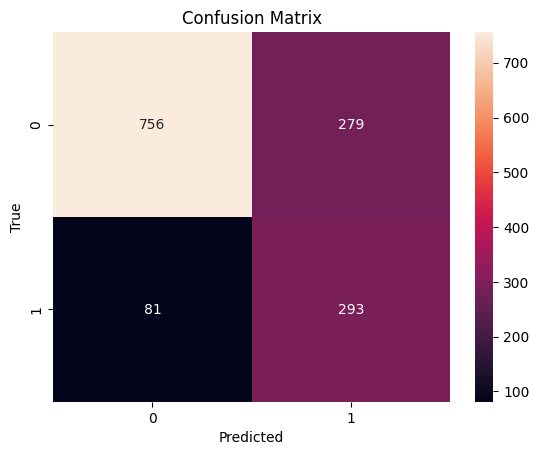

In [88]:
# matrix de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

# matrice de confusion avec seaborn
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
# met le titre
plt.title('Confusion Matrix')
# met les labels
plt.xlabel('Predicted')
plt.ylabel('True')
# affiche
plt.show()

In [92]:
from sklearn.ensemble import RandomForestClassifier

# Crée un random forest avec des hyperparamètres personnalisés
rf = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_split=2,
                            min_samples_leaf=2, max_features='auto', random_state=42,
                            class_weight='balanced', n_jobs=-1, verbose=1 , criterion='entropy')

# Crée un pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', rf)
])

# Crée un run
with mlflow.start_run() as run:
    # Fit le modèle
    pipe.fit(X_train, y_train)
    # Prédit le test set
    y_pred = pipe.predict(X_test)
    # Évalue le modèle
    score = f1_score(y_test, y_pred , average='macro')
    print(f"F1 Score: {score}")
    
    # Log model
    mlflow.sklearn.log_model(pipe, "model")
    
    mlflow.log_metric("F1 Score", score)

/home/apprenant/miniconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/apprenant/miniconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using 

F1 Score: 0.7378218622002841
